
<img alt='UCL' src="images/ucl_logo.png" align='center'>


[<img src="images/noun_post_2109127.svg" width="50" align='right'>](036_Model_Fitting.ipynb)
[<img src="images/noun_pre_2109128.svg" width="50" align='right'>](034_Weigthed_smoothing_and_interpolation.ipynb)



# 035 Weighted interpolation

##  Introduction

### Purpose

We have seen in [034_Weigthed_smoothing_and_interpolation](034_Weigthed_smoothing_and_interpolation.ipynb) how we can regularise a dataset using colvolution filtering. We investigate and apply that now to allow us to provide gap-filled datasets.

### Prerequisites

You must make sure you can recall the details of the work covered in [032_GDAL_mosaicing_and_masking](032_GDAL_mosaicing_and_masking.ipynb) and understand the material in [034_Weigthed_smoothing_and_interpolation](034_Weigthed_smoothing_and_interpolation.ipynb). You will also need to know how to do [graph plotting](023_Plotting.ipynb), including sub-figures and errorbars, and [image display](024_Image_display.ipynb).

## Smoothing

In convolution, we combine a *signal* $y$ with a *filter* $f$ to achieve a filtered signal. For example, if we have an noisy signal, we will attempt to reduce the influence of high frequency information in the signal (a 'low pass' filter, as we let the low frequency information *pass*).

We can perform a weighted interpolation by:

* numerator   = smooth( signal $\times$ weight)
* denominator = smooth( weight)
* result = numerator/denominator

In [9]:
import gdal
import matplotlib.pyplot as plt
from geog0111.modis_annual import modis_annual
import numpy as np

# load some data

warp_args = {
  'dstNodata'     : 255,
  'format'        : 'MEM',
  'cropToCutline' : True,
  'cutlineWhere'  : "FIPS='LU'",
  'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}
sds     = ['Lai_500m','LaiStdDev_500m','FparLai_QC']
tile    = ['h17v03','h18v03','h17v04','h18v04']
product = 'MCD15A3H'
year    = 2019
    
mfiles = modis_annual(year,tile,product,sds=sds,warp_args=warp_args)

# apply weights as previously

lai = mfiles['Lai_500m'] * 0.1
std = mfiles['LaiStdDev_500m'] * 0.1

std[std<1] = 1
weight = np.zeros_like(std)
mask = (std > 0)
weight[mask] = 1./(std[mask]**2)
weight[lai > 10] = 0.

# look at some stats
print(weight.min(),weight.max())

we dont need to process MCD15A3H._h17v03_h18v03_h17v04_h18v04_.2019
0.0 1.0


Text(0, 0.5, 'LAI')

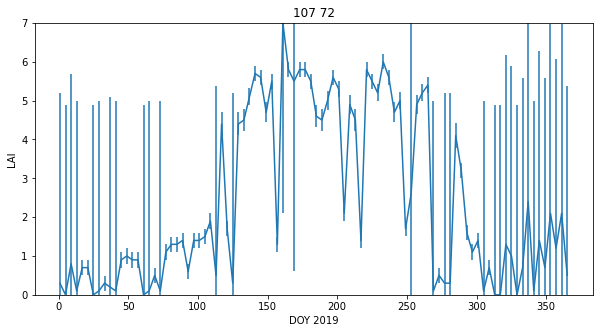

In [10]:
import matplotlib.pyplot as plt

error = np.zeros_like(weight)
error[weight>0] = np.sqrt(1./(weight[weight>0] )) * 1.97

doy = [int(i.split('-')[1]) for i in mfiles['bandnames']]
p0,p1 = (107,72)
x_size,y_size=(10,5)

shape=(10,10)
fig, axs = plt.subplots(1,1,figsize=(x_size,y_size))
x = doy

axs.errorbar(x,lai[:,p0,p1],yerr=error[:,p0,p1]/10)
axs.set_title(f'{p0} {p1}')
# ensure the same scale for all
axs.set_ylim(0,7)
axs.set_xlabel('DOY 2019')
axs.set_ylabel('LAI')

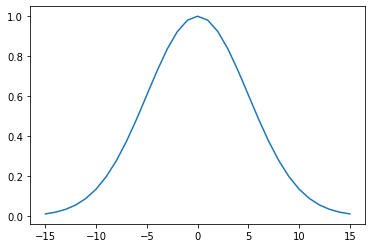

In [11]:
import scipy
import scipy.ndimage.filters

sigma = 5

x = np.arange(-3*sigma,3*sigma+1)
gaussian = np.exp((-(x/sigma)**2)/2.0)

plt.plot(x,gaussian)

numerator = scipy.ndimage.filters.convolve1d(lai * weight, gaussian, axis=0,mode='wrap')
denominator = scipy.ndimage.filters.convolve1d(weight, gaussian, axis=0,mode='wrap')

# avoid divide by 0 problems by setting zero values
# of the denominator to not a number (NaN)
denominator[denominator==0] = np.nan

interpolated_lai = numerator/denominator

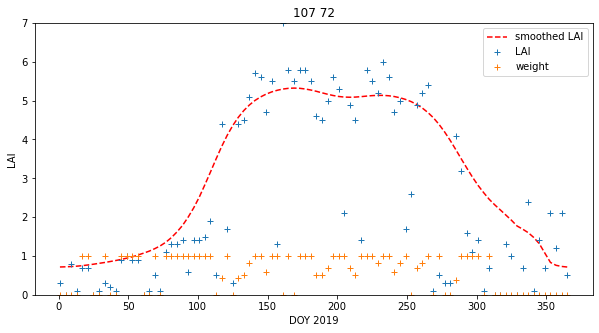

In [12]:
p0,p1 = (107,72)
x_size,y_size=(10,5)

fig, axs = plt.subplots(1,1,figsize=(x_size,y_size))
x = doy
axs.plot(x,interpolated_lai[:,p0,p1],'r--',label='smoothed LAI')
axs.plot(x,lai[:,p0,p1],'+',label='LAI')
axs.plot(x,weight[:,p0,p1],'+',label='weight')

axs.set_title(f'{p0} {p1}')
# ensure the same scale for all
axs.set_ylim(0,7)
axs.set_xlabel('DOY 2019')
axs.set_ylabel('LAI')
axs.legend(loc='best')

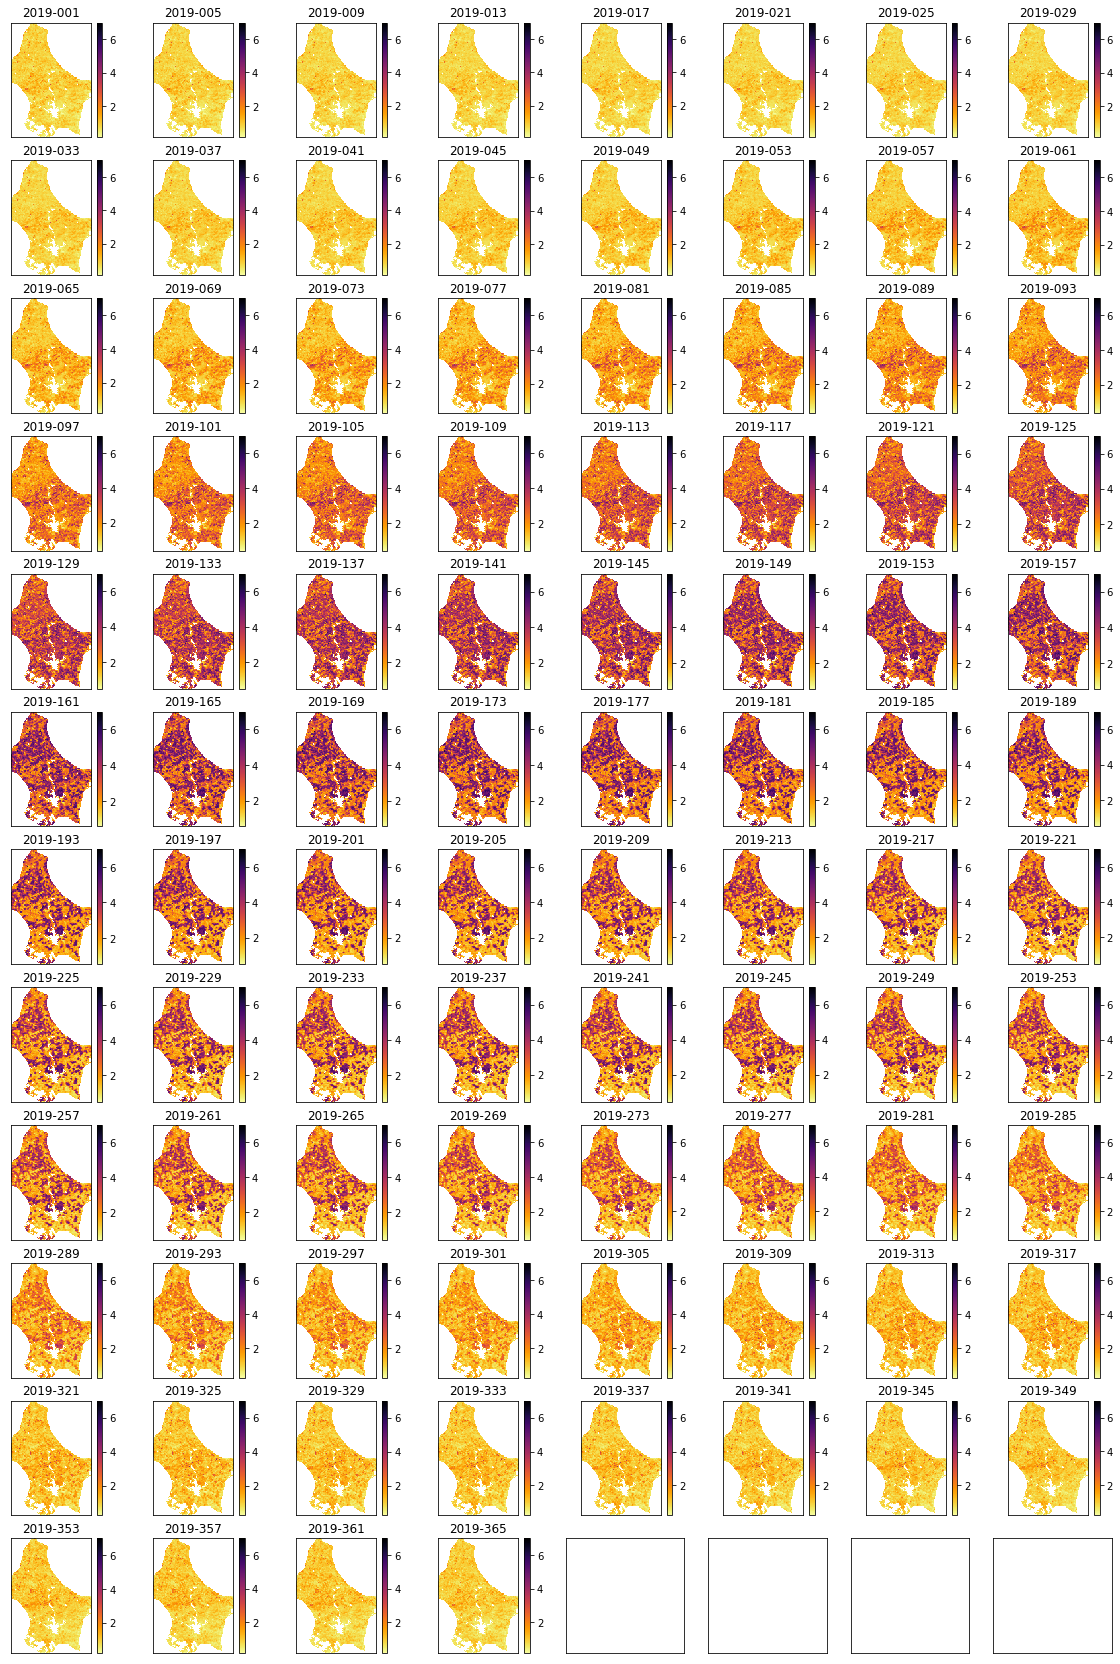

In [16]:
# Plot the interpolated_lai
import matplotlib.pyplot as plt

shape=(12,8)
x_size,y_size=(20,30)

fig, axs = plt.subplots(*shape,figsize=(x_size,y_size))
axs = axs.flatten()
plt.setp(axs, xticks=[], yticks=[])

for i in range(interpolated_lai.shape[0]):
    im = axs[i].imshow(interpolated_lai[i],vmax=7,cmap=plt.cm.inferno_r,\
                       interpolation='nearest')
    axs[i].set_title(mfiles['bandnames'][i])
    fig.colorbar(im, ax=axs[i])

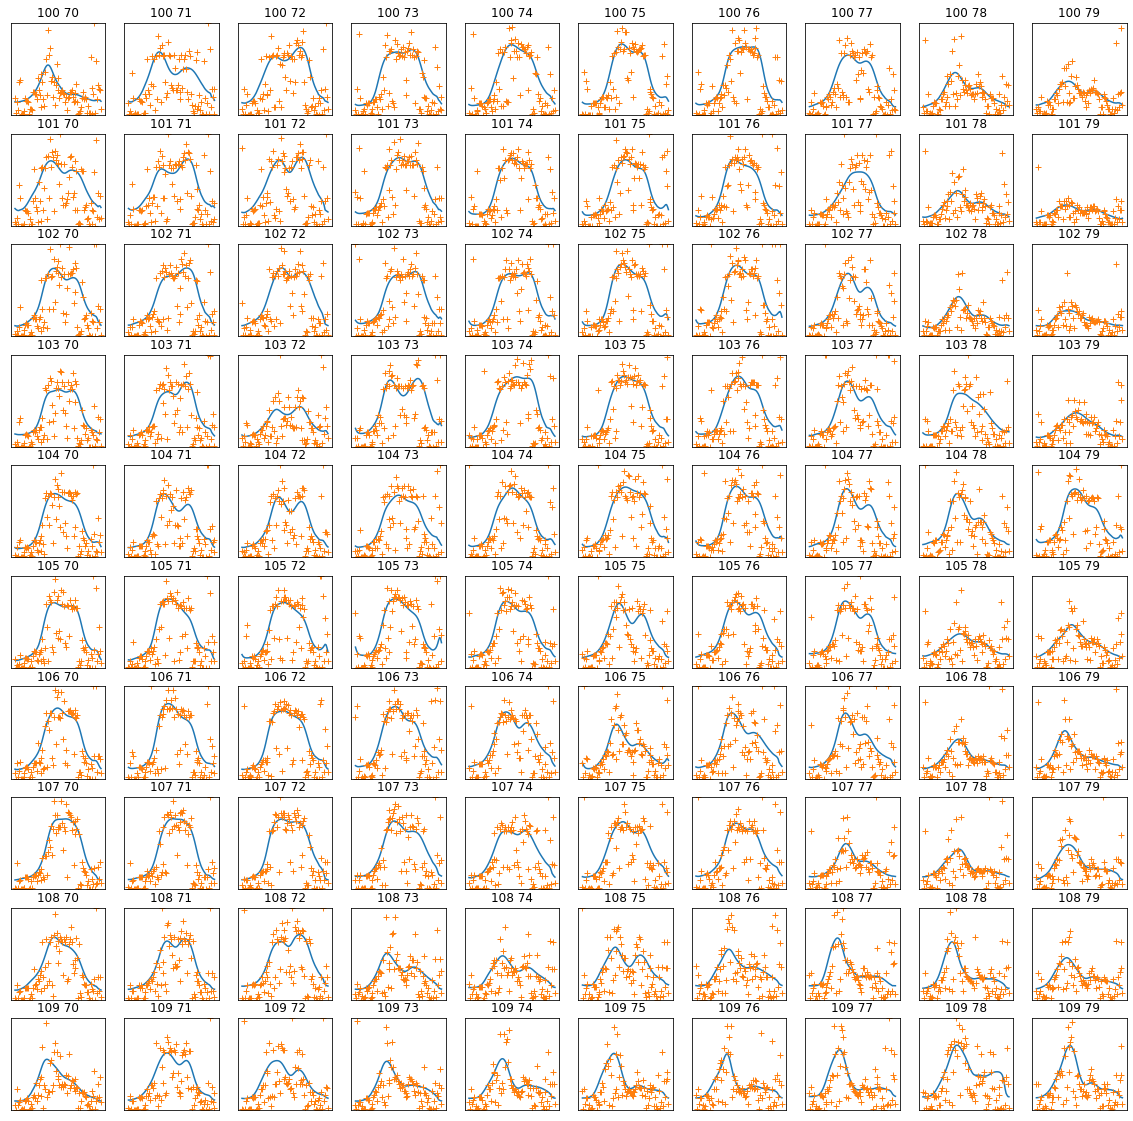

In [17]:
import matplotlib.pyplot as plt

x_size,y_size=(20,20)

shape=(10,10)
fig, axs = plt.subplots(*shape,figsize=(x_size,y_size))
plt.setp(axs, xticks=[], yticks=[])

pixel = (100,70)
x = doy

for i in range(shape[0]):
    p0 = pixel[0] + i
    for j in range(shape[1]):
        p1 = pixel[1] + j
        axs[i,j].plot(x,interpolated_lai[:,p0,p1])
        axs[i,j].plot(x,lai[:,p0,p1],'+')
        axs[i,j].set_title(f'{p0} {p1}')
        # ensure the same scale for all
        axs[i,j].set_ylim(0,7)

## data mask

Although these datasets look complete when we plot them, it is still possible that some pixels have no valid data points or invalid pixels. Earlier, we set 

        denominator[denominator==0] = np.nan

so we would expect invalid pixels to contain `np.nan`. We can build a mask for these pixels, for example by summing along the time axis (axis 0):

        mask = np.sum(interpolated_lai,axis=0)
        
This will build a 2D dataset that is `np.nan` if incvalid. We can then use `~np.isnan` to build a boolean mask. The `~` symbol is the same as doing `np.logical_not()` in this context. It will be `True` where invalid, and `False` where valid:

Text(0.5, 1.0, 'data mask')

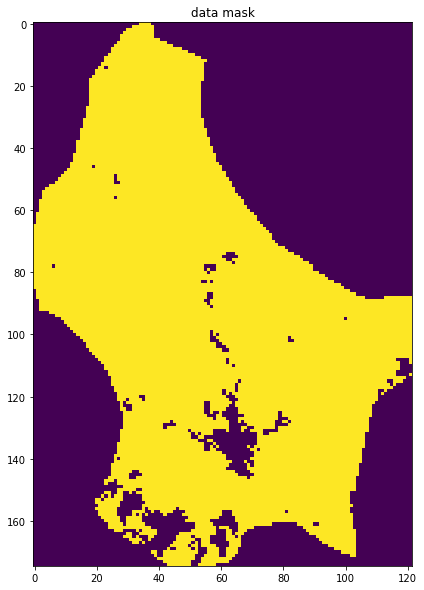

In [70]:
mask = ~np.isnan(np.sum(interpolated_lai,axis=0))

x_size,y_size=(10,10)
fig, axs = plt.subplots(1,1,figsize=(x_size,y_size))
x = doy
axs.imshow(mask)
axs.set_title('data mask')

Lets now load some land cover data:

We will use `LC_Type3` as this is the classification associated with the LAI product. You will find a CSV file defining the LC types in [`data/LC_Type3_colour.csv`](data/LC_Type3_colour.csv).


In [54]:
from geog0111.modis import Modis

# LU
kwargs = {
    'tile'      :    ['h17v03', 'h18v03','h17v04', 'h18v04'],
    'product'   :    'MCD12Q1',
}

year  = 2019
doy = 1
# get the data
modis = Modis(**kwargs)

warp_args = {
    'dstNodata'     : 255,
    'format'        : 'MEM',
    'cropToCutline' : True,
    'cutlineWhere'  : "FIPS='LU'",
    'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}

# specify day of year (DOY) and year
lcfiles = modis.get_modis(year,doy,warp_args=warp_args)
lcfiles.keys()

dict_keys(['LC_Prop1', 'LC_Prop1_Assessment', 'LC_Prop2', 'LC_Prop2_Assessment', 'LC_Prop3', 'LC_Prop3_Assessment', 'LC_Type1', 'LC_Type2', 'LC_Type3', 'LC_Type4', 'LC_Type5', 'LW', 'QC', 'bandnames'])

In [55]:
import pandas as pd
# read the colour data
lc_Type3 = pd.read_csv('data/LC_Type3_colour.csv')
lc_Type3

,code,colour,class,description
0,0,#1c0dff,Water Bodies,at least 60% of area is covered by permanent w...
1,1,#b6ff05,Grasslands,dominated by herbaceous annuals (<2m) includin...
2,2,#dcd159,Shrublands,shrub (1-2m) cover >10%.
3,3,#c24f44,Broadleaf,Croplands: bominated by herbaceous annuals (<2...
4,4,#fbff13,Savannas,between 10-60% tree cover (>2m).
5,5,#086a10,Evergreen Broadleaf Forests,dominated by evergreen broadleaf and palmate t...
6,6,#78d203,Deciduous Broadleaf Forests,dominated by deciduous broadleaf trees (canopy...
7,7,#05450a,Evergreen Needleleaf Forests,dominated by evergreen conifer trees (canopy >...
8,8,#54a708,Deciduous Needleleaf Forests,dominated by deciduous needleleaf (larch) tree...
9,9,#f9ffa4,Non-Vegetated Lands,at least 60% of area is non-vegetated barren (...


In [56]:
# generate matplotlib cmap and norm objects from these
# as in session 024
import matplotlib
import matplotlib.patches

cmap = matplotlib.colors.\
        ListedColormap(list(lc_Type3['colour']))
norm = matplotlib.colors.\
        BoundaryNorm(list(lc_Type3['code']), len(lc_Type3['code']))

# set up the legend
legend_labels = dict(zip(list(lc_Type3['colour']),list(lc_Type3['class'])))
patches = [matplotlib.patches.Patch(color=c, label=l)
           for c,l in legend_labels.items()]

In [57]:
import gdal
import numpy as np

# read the LC_Type3 dataset
g = gdal.Open(lcfiles['LC_Type3'])
land_cover = g.ReadAsArray()
print(np.unique(land_cover))
print(lcfiles['LC_Type3'])

[  1   3   4   5   6   7  10 255]
/shared/groups/jrole001/geog0111/work/MCD12Q1/data.LC_Type3._h17v03_h18v03_h17v04_h18v04_.2019.001.001_warp.vrt


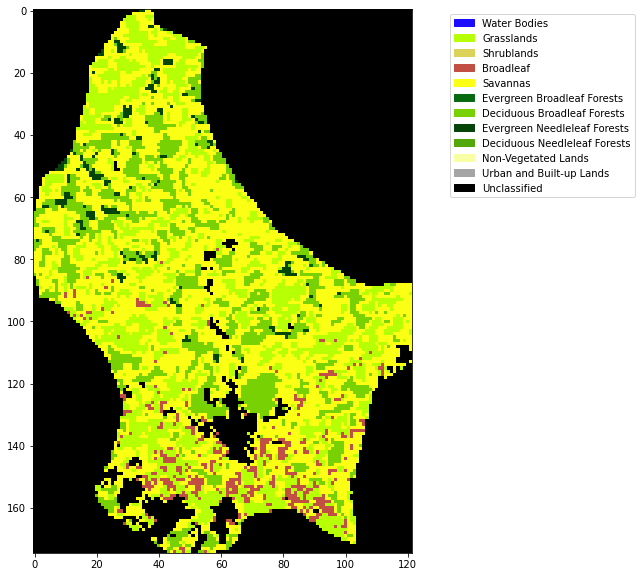

In [59]:
# plot
import matplotlib.pyplot as plt
x_size,y_size=(10,10)
fig, axs = plt.subplots(1,figsize=(x_size,y_size))
im = axs.imshow(land_cover,cmap=cmap,norm=norm,interpolation='nearest')
plt.legend(handles=patches,
          bbox_to_anchor=(1.6, 1),
          facecolor="white")

We can now consider masking both for valid pixels and for a particular land cover type.

In [68]:
# get the code for Grasslands
# might be easier to look in the table ...
# but we can extract it
classy = 'Grasslands'
code = int(lc_Type3['code'][lc_Type3['class'] == classy])
print(f'code for {classy} is {code}')

code for Grasslands is 1


In [72]:
# code 
code_mask = (land_cover == code)
valid_mask = ~np.isnan(np.sum(interpolated_lai,axis=0))

# combine
mask = np.logical_and(code_mask,valid_mask)
masked_lai = interpolated_lai[:,mask]
print(masked_lai.shape)

(92, 2661)


Notice how we used `interpolated_lai[:,mask]` to apply the mask to the last 2 dimensions of the `interpolated_laia dataset. The result is 2D, the first dimension being the number of time samples.

Now, take the mean, over axis 1:

In [77]:
mean_lai = np.mean(interpolated_lai[:,mask],axis=(1))
median_lai = np.median(interpolated_lai[:,mask],axis=(1))
max_lai = np.max(interpolated_lai[:,mask],axis=(1))
min_lai = np.min(interpolated_lai[:,mask],axis=(1))

# get the doy data as above
doy = np.array([int(i.split('-')[1]) for i in mfiles['bandnames']])

# check they have the same shape before we plot them!
grass_lai.shape,doy.shape

((92,), (92,))

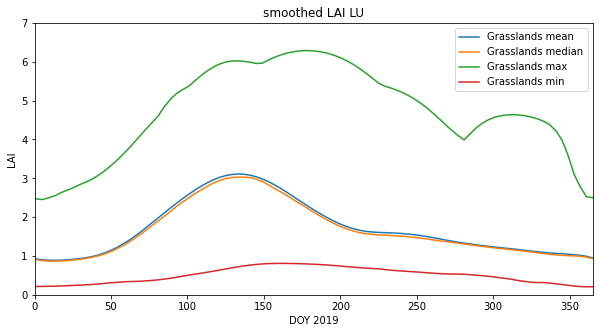

In [82]:
# plot 
x_size,y_size=(10,5)

fig, axs = plt.subplots(1,1,figsize=(x_size,y_size))
x = doy
axs.plot(x,mean_lai,label=f"{classy} mean")
axs.plot(x,median_lai,label=f"{classy} median")
axs.plot(x,max_lai,label=f"{classy} max")
axs.plot(x,min_lai,label=f"{classy} min")
axs.set_title(f'smoothed LAI LU')
# ensure the same scale for all
axs.set_ylim(0,7)
axs.set_ylabel('LAI')
axs.set_xlabel('DOY 2019')
axs.set_xlim(0,365)
axs.legend(loc='upper right')

#### Exercise 1

* Produce plots of summary statistics for each land cover in the dataset
* Compare LAI for two countries withing the bounds of the dataset, for given land cover classes.

## Summary

From this session, you should be able to acquire a MODIS timeseries dataset and associated land cover map. You should be able to treat the data, so that by defining a weight for weach observation, you can produce a regularised (smoothed, interpolated) dataset from original noisy observations. In this case, we used variable weighting, according to an uncertainty measure, but if that is not available, you can simply use a weight of 1 for a valid observation and 0 when there is no valid value. 

You should then be able to calculate statistics from the data. You should be capable of doing this for any MODIS geophysical variable, and also of developing functiuons that bring some of these ideas together into more compact, reusable code.


[<img src="images/noun_post_2109127.svg" width="50" align='right'>](036_Model_Fitting.ipynb)
[<img src="images/noun_pre_2109128.svg" width="50" align='right'>](034_Weigthed_smoothing_and_interpolation.ipynb)


